# Segmenting and Clustering Neighborhoods in London

We would explore, segment, and cluster the neighborhoods in the city of London. 

Use the Notebook to build the code to scrape the following Wikipedia page: https://en.wikipedia.org/wiki/List_of_areas_of_London

We will use for web scraping the BeautifulSoup package. Here is the package's main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/

In [1]:
#Import all the required libraries
import pandas as pd
import numpy as np
import requests
import json
!pip install bs4 #install up to date beautiful soup 4
from bs4 import BeautifulSoup
!pip install lxml
!pip install html5lib
import urllib.request
#Import required libraries and modules to get geo data
!pip install geocoder
import geocoder #import geocoder
!pip install geopy
from geopy.geocoders import Nominatim #convert an address into latitude and longitude values
#import libraries required for plotting charts and maps
import matplotlib as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as colors
!pip install folium
import folium
%matplotlib inline
#For clustering
from sklearn.cluster import KMeans #import k-means from clustering stage
print('Libraries imported.')

     |████████████████████████████████| 112kB 7.0MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
     |████████████████████████████████| 5.8MB 6.3MB/s eta 0:00:01     |█▌                              | 266kB 6.3MB/s eta 0:00:01
     |████████████████████████████████| 102kB 11.8MB/s ta 0:00:01
     |████████████████████████████████| 92kB 5.5MB/s  eta 0:00:01
     |████████████████████████████████| 829kB 8.6MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
     |████████████████████████████████| 122kB 6.3MB/s eta 0:00:01
Libraries imported.


## 1. Data Sources

## 1.1 Neighbourhoods

First, We will scrape the data of postal codes of London neighborhoods from wikipedia: https://en.wikipedia.org/wiki/List_of_areas_of_London. We will start by retrieving the table information using the BeautifulSoup package.

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
page = urllib.request.urlopen(url)
from bs4 import BeautifulSoup
soup = BeautifulSoup(page, 'html5lib')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of areas of London - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"XsBwhQpAAEEAAHfGbYAAAADN","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_areas_of_London","wgTitle":"List of areas of London","wgCurRevisionId":947527724,"wgRevisionId":947527724,"wgArticleId":11915713,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Use dmy dates from August 2015","Use British English from August 2015","Lists of coordinates","Geo

In [3]:
table = soup.find('table', {'class': 'wikitable sortable'}).tbody
print(table)

<tbody><tr>
<th>Location</th>
<th>London borough</th>
<th>Post town</th>
<th>Postcode district</th>
<th>Dial code</th>
<th>OS grid ref
</th></tr>
<tr>
<td><a href="/wiki/Abbey_Wood" title="Abbey Wood">Abbey Wood</a></td>
<td>Bexley,  Greenwich <sup class="reference" id="cite_ref-mills1_7-0"><a href="#cite_note-mills1-7">[7]</a></sup></td>
<td>LONDON</td>
<td>SE2</td>
<td>020</td>
<td><span class="plainlinks nourlexpansion" style="white-space: nowrap"><a class="external text" href="https://tools.wmflabs.org/geohack/en/51.48648031512;0.10859224316653_region:GB_scale:25000?pagename=List_of_areas_of_London">TQ465785</a></span>
</td></tr>
<tr>
<td><a href="/wiki/Acton,_London" title="Acton, London">Acton</a></td>
<td>Ealing, Hammersmith and Fulham<sup class="reference" id="cite_ref-mills2_8-0"><a href="#cite_note-mills2-8">[8]</a></sup></td>
<td>LONDON</td>
<td>W3, W4</td>
<td>020</td>
<td><span class="plainlinks nourlexpansion" style="white-space: nowrap"><a class="external text" href="htt

th has the header names and td cell information


In [4]:
rows = table.findAll('tr')
columns = [v.text.replace('\xa0', ' ').replace('\n', '') for v in rows[0].findAll('th')]
print(columns)

['Location', 'London borough', 'Post town', 'Postcode district', 'Dial code', 'OS grid ref']


In [5]:
df = pd.DataFrame(columns = columns)
df.head()

Empty DataFrame
Columns: [Location, London borough, Post town, Postcode district, Dial code, OS grid ref]
Index: []

In [6]:
#pupulate the table - start from the 1st row not to get hte headers
for i in range(1, len(rows)):
    tds = rows[i].findAll('td')
    if len(tds) == 6:
        values = [tds[0].text, 
                  tds[1].text.replace(r"\[.*?\]", "").rstrip(), 
                  tds[2].text,
                  tds[3].text, 
                  tds[4].text, 
                  tds[5].text.replace('\n', '')]
    df = df.append(pd.Series(values, index = columns), ignore_index = True)
df.head()

Location                     London borough       Post town  \
0   Abbey Wood             Bexley,  Greenwich [7]          LONDON   
1        Acton  Ealing, Hammersmith and Fulham[8]          LONDON   
2    Addington                         Croydon[8]         CROYDON   
3   Addiscombe                         Croydon[8]         CROYDON   
4  Albany Park                             Bexley  BEXLEY, SIDCUP   

  Postcode district Dial code OS grid ref  
0               SE2       020    TQ465785  
1            W3, W4       020    TQ205805  
2               CR0       020    TQ375645  
3               CR0       020    TQ345665  
4         DA5, DA14       020    TQ478728

### Cleaning the table

In [7]:
df.drop(['Dial code', 'OS grid ref'], axis = 1)

Location                     London borough       Post town  \
0         Abbey Wood             Bexley,  Greenwich [7]          LONDON   
1              Acton  Ealing, Hammersmith and Fulham[8]          LONDON   
2          Addington                         Croydon[8]         CROYDON   
3         Addiscombe                         Croydon[8]         CROYDON   
4        Albany Park                             Bexley  BEXLEY, SIDCUP   
..               ...                                ...             ...   
528         Woolwich                          Greenwich          LONDON   
529   Worcester Park       Sutton, Kingston upon Thames  WORCESTER PARK   
530  Wormwood Scrubs             Hammersmith and Fulham          LONDON   
531          Yeading                         Hillingdon           HAYES   
532         Yiewsley                         Hillingdon    WEST DRAYTON   

    Postcode district  
0                 SE2  
1              W3, W4  
2                 CR0  
3                 CR0  
4           DA5, DA14  
..                ...  
528              SE18  
529               KT4  
530               W12  
531               UB4  
532               UB7  

[533 rows x 4 columns]

In [8]:
df['London borough'] = df['London borough'].apply(lambda x: x.replace('[', '').replace(']', '')) #remove the [ ] in the london borough
df['London borough'] =  df['London borough'].str.replace('\d+', '') #remove the number from london borough
df['London borough'] =  df['London borough'].str.split(',').str[0] #remove the second london borough and assign the first from the two
df['Postcode district'] =  df['Postcode district'].str.split(',').str[0] #remove the multiple postcodes and keep the first one *Assumption
df['Postcode district'] =  df['Postcode district'].str.split('(').str[0] #remove the parenthesis and keep ony the first part postcode
df['Post town'] =  df['Post town'].str.split(',').str[0] #remove the second assigned post town and assign only the first
df.head()

Location London borough Post town Postcode district Dial code  \
0   Abbey Wood         Bexley    LONDON               SE2       020   
1        Acton         Ealing    LONDON                W3       020   
2    Addington        Croydon   CROYDON               CR0       020   
3   Addiscombe        Croydon   CROYDON               CR0       020   
4  Albany Park         Bexley    BEXLEY               DA5       020   

  OS grid ref  
0    TQ465785  
1    TQ205805  
2    TQ375645  
3    TQ345665  
4    TQ478728

In [9]:
df['Postcode district'].unique()

array(['SE2', 'W3', 'CR0', 'DA5', 'IG2', 'EC3', 'WC2', 'HA0', 'SE20',
       'EC1', 'TN16', 'N19', 'RM11', 'EN5', 'N11', 'SW12', 'SE1', 'IG11',
       'IG6', 'DA7', 'SW13', 'DA1', 'NW7', 'N1', 'SW11', 'W2', 'BR3',
       'E6', 'RM9', 'RM8', 'SM6', 'W4', 'SW1', 'SE6', 'HA3', 'SM2', 'NW3',
       'DA17', 'KT5', 'E2', 'DA6', 'DA15', 'EC4', 'SE3', 'E14', 'DA 5',
       'WC1', 'EN2', 'E3', 'N22', 'TW8', 'NW2', 'NW10', 'EN3', 'SW2',
       'SE4', 'BR1', 'SW3', 'NW6', 'HA8', 'NW4', 'SE5', 'NW1', 'E11',
       'E16', 'SM5', 'RM6', 'SE7', 'RM5', 'SM1 ', 'BR6', 'KT9', 'W1',
       'SE12', 'E4', 'BR7', 'N3', 'SW4', 'EN4', 'NW9', 'SW19', 'DA8',
       'BR4', 'KT2', 'CR5', 'UB8', 'TW5', 'RM14', 'N8', 'SE19', 'TN14',
       'E8', 'SE8', 'BR5', 'SE21', 'W5', 'SW5', 'SW18', 'TW14', 'SE22',
       'N2', 'SW14', 'DA16', 'HA5', 'N9', 'TW1', 'RM12', 'SE9', 'EN1',
       'TW13', 'N4', 'DA14', 'E7', 'SE23', 'N10', 'SW6', 'TW11', 'RM2',
       'NW11', 'IG3', 'NW5', 'N21', 'UB6', 'SE10', 'E5', 'E9', 'IG7',
  

In [10]:
df['Location'].unique()

array(['Abbey Wood', 'Acton', 'Addington', 'Addiscombe', 'Albany Park',
       'Aldborough Hatch', 'Aldgate', 'Aldwych', 'Alperton', 'Anerley',
       'Angel', 'Aperfield', 'Archway', 'Ardleigh Green', 'Arkley',
       'Arnos Grove', 'Balham', 'Bankside', 'Barbican', 'Barking',
       'Barkingside', 'Barnehurst', 'Barnes', 'Barnes Cray',
       'Barnet Gate', 'Barnet (also Chipping Barnet, High Barnet)',
       'Barnsbury', 'Battersea', 'Bayswater', 'Beckenham', 'Beckton',
       'Becontree', 'Becontree Heath', 'Beddington', 'Bedford Park',
       'Belgravia', 'Bellingham', 'Belmont', 'Belsize Park', 'Belvedere',
       'Bermondsey', 'Berrylands', 'Bethnal Green',
       'Bexley (also Old Bexley, Bexley Village)',
       'Bexleyheath (also Bexley New Town)', 'Bickley', 'Biggin Hill',
       'Blackfen', 'Blackfriars', 'Blackheath',
       'Blackheath Royal Standard', 'Blackwall', 'Blendon', 'Bloomsbury',
       'Botany Bay', 'Bounds Green', 'Bow', 'Bowes Park', 'Brentford',
       'Bren

In [11]:
df['London borough'].unique()

array(['Bexley', 'Ealing', 'Croydon', 'Redbridge', 'City', 'Westminster',
       'Brent', 'Bromley', 'Islington', 'Havering', 'Barnet', 'Enfield',
       'Wandsworth', 'Southwark', 'Barking and Dagenham',
       'Richmond upon Thames', 'Newham', 'Sutton', 'Lewisham', 'Harrow',
       'Camden', 'Kingston upon Thames', 'Tower Hamlets', 'Greenwich',
       'Haringey', 'Hounslow', 'Lambeth',
       'Kensington and ChelseaHammersmith and Fulham', 'Waltham Forest',
       'Kensington and Chelsea', 'Merton', 'Hillingdon', 'Hackney',
       'Dartford', 'Islington & City', 'Hammersmith and Fulham',
       'Camden and Islington', 'Haringey and Barnet'], dtype=object)

In [12]:
df['Post town'].unique()

array(['LONDON', 'CROYDON', 'BEXLEY', 'ILFORD', 'WEMBLEY', 'WESTERHAM',
       'HORNCHURCH', 'BARNET', 'BARKING', 'BEXLEYHEATH', 'DARTFORD',
       'BECKENHAM', 'DAGENHAM', 'WALLINGTON', 'HARROW', 'SUTTON',
       'BELVEDERE', 'SURBITON', 'BROMLEY', 'SIDCUP', 'ENFIELD',
       'BRENTFORD', 'EDGWARE', 'CARSHALTON', 'ROMFORD', 'SUTTON/MERTON',
       'ORPINGTON', 'CHESSINGTON', 'CHISLEHURST', 'ERITH', 'WEST WICKHAM',
       'KINGSTON UPON THAMES', 'COULSDON', 'UXBRIDGE', 'HOUNSLOW',
       'UPMINSTER', 'SEVENOAKS', 'FELTHAM', 'WELLING', 'PINNER',
       'TWICKENHAM', 'TEDDINGTON', 'GREENFORD', 'CHIGWELL', 'RICHMOND',
       'HAMPTON', 'HAYES', 'WEST DRAYTON', 'ISLEWORTH', 'KENLEY',
       'KESTON', 'MORDEN', 'MITCHAM', 'NEW MALDEN', 'NORTHOLT',
       'NORTHWOOD', 'SOUTHALL', 'WORCESTER PARK', 'PURLEY', 'RAINHAM',
       'RUISLIP', 'SOUTH CROYDON', 'STANMORE', 'THORNTON HEATH'],
      dtype=object)

In [13]:
df_cleaned = df.drop(['Dial code', 'OS grid ref'], axis = 1)

In [14]:
df_cleaned.head()

Location London borough Post town Postcode district
0   Abbey Wood         Bexley    LONDON               SE2
1        Acton         Ealing    LONDON                W3
2    Addington        Croydon   CROYDON               CR0
3   Addiscombe        Croydon   CROYDON               CR0
4  Albany Park         Bexley    BEXLEY               DA5

In [15]:
df_cleaned.shape

(533, 4)

## 1.2 Propery value

Getting the property data with pandas read html (to use a different method than BeautifulSoup). This site was used: https://propertydata.co.uk/cities/london

In [16]:
# property_tables = pd.read_html('https://propertydata.co.uk/cities/london',header=0)
# for property_table in property_tables:
#     print(property_table)

In [17]:
# The code was removed by Watson Studio for sharing.

        0          1           2       3        4             5
0    Area  Avg yield   Avg price  £/sqft  5yr +/-  Explore data
1     BR1       3.6%    £434,986    £462     +23%  Explore data
2     BR2       3.0%    £510,478    £476     +24%  Explore data
3     BR3       3.4%    £455,860    £493     +24%  Explore data
4     BR5       3.3%    £450,548    £428     +25%  Explore data
..    ...        ...         ...     ...      ...           ...
208   W12       2.9%    £760,124    £802     +12%  Explore data
209   W13       3.1%    £579,287    £680     +11%  Explore data
210   W14       2.7%    £874,941    £996      +5%  Explore data
211   WC1       3.0%    £896,416  £1,169      +2%  Explore data
212   WC2       2.0%  £1,662,350  £1,635      +3%  Explore data

[213 rows x 6 columns]


In [18]:
df_value.columns = df_value.iloc[0]
df_value.drop(df_value.index[0], inplace = True)
df_value.head()

0 Area Avg yield Avg price £/sqft 5yr +/-  Explore data
1  BR1      3.6%  £434,986   £462    +23%  Explore data
2  BR2      3.0%  £510,478   £476    +24%  Explore data
3  BR3      3.4%  £455,860   £493    +24%  Explore data
4  BR5      3.3%  £450,548   £428    +25%  Explore data
5  BR6      3.3%  £544,548   £469    +24%  Explore data

In [19]:
df_value.shape

(212, 6)

### Cleaning property data

In [20]:
df_value = df_value.drop(columns = ['Avg yield', '5yr +/-', 'Explore data'],  axis = 1) #remove all the columns but the avg price and £/sqft
#remove the '£' and ',' from both also update to £/sqm
df_value['Avg price'] = df_value['Avg price'].str.replace('£','')
df_value['Avg price'] = df_value['Avg price'].str.replace(',','')
df_value['£/sqft'] = df_value['£/sqft'].str.replace('£','')
df_value['£/sqft'] = df_value['£/sqft'].str.replace(',','')
#update both to numeric
df_value['Avg price'] = pd.to_numeric(df_value['Avg price'])
df_value['£/sqft'] = pd.to_numeric(df_value['£/sqft'])
df_value['£/sqft'] = df_value['£/sqft'] *10.764
df_value=df_value.rename(columns = {'£/sqft':'£/sqm'})
df_value['£/sqm'] = df_value['£/sqm'].round(1)
df_value

0   Area  Avg price    £/sqm
1    BR1     434986   4973.0
2    BR2     510478   5123.7
3    BR3     455860   5306.7
4    BR5     450548   4607.0
5    BR6     544548   5048.3
..   ...        ...      ...
208  W12     760124   8632.7
209  W13     579287   7319.5
210  W14     874941  10720.9
211  WC1     896416  12583.1
212  WC2    1662350  17599.1

[212 rows x 3 columns]

In [21]:
df_value.reset_index(drop=True, inplace=True)
df_value.head()

0 Area  Avg price   £/sqm
0  BR1     434986  4973.0
1  BR2     510478  5123.7
2  BR3     455860  5306.7
3  BR5     450548  4607.0
4  BR6     544548  5048.3

In [22]:
df_value=df_value.rename(columns = {'Area':'Postcode district'})
df_value.head()

0 Postcode district  Avg price   £/sqm
0               BR1     434986  4973.0
1               BR2     510478  5123.7
2               BR3     455860  5306.7
3               BR5     450548  4607.0
4               BR6     544548  5048.3

#### Merge the two tables (there are not all the postcodes in the df_value as in the df_cleaned)
That's why we are using Inner Join

In [23]:
merged_inner = pd.merge(left=df_cleaned, right=df_value, left_on='Postcode district', right_on='Postcode district') #we dont have to have how = 'inner' as it is the default
merged_inner.shape

(515, 6)

In [24]:
merged_inner.head()

Location London borough Post town Postcode district  Avg price   £/sqm
0  Abbey Wood         Bexley    LONDON               SE2     368814  4133.4
1   Crossness         Bexley    LONDON               SE2     368814  4133.4
2  West Heath         Bexley    LONDON               SE2     368814  4133.4
3       Acton         Ealing    LONDON                W3     547488  7330.3
4   Addington        Croydon   CROYDON               CR0     347577  4757.7

## 1.3 Getting coordinates

#### Lets assign Latitudes and Longitudes

#### We are going to look mainly in London post town, so we will keep only those that are in Central London

In [25]:
london_data = merged_inner[merged_inner['Post town'] == 'LONDON'].reset_index(drop=True)
london_data.head()

Location London borough Post town Postcode district  Avg price    £/sqm
0  Abbey Wood         Bexley    LONDON               SE2     368814   4133.4
1   Crossness         Bexley    LONDON               SE2     368814   4133.4
2  West Heath         Bexley    LONDON               SE2     368814   4133.4
3       Acton         Ealing    LONDON                W3     547488   7330.3
4     Aldwych    Westminster    LONDON               WC2    1662350  17599.1

In [26]:
london_data.shape

(300, 6)

In [27]:
# define the geocoder function
def get_geocoder(postal_code_from_df):
    lat_lng_coords = None #initialise your variable to None
    #loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London'.format(postal_code_from_df))
        lat_lng_coords = g.latlng
    neigh_lat = lat_lng_coords[0]
    neigh_lng = lat_lng_coords[1]
    return neigh_lat, neigh_lng

In [28]:
#loop in our df and create a post_TorontoNeigh
post_london_data = london_data
post_london_data['Latitude'], post_london_data['Longitude'] = zip(*post_london_data['Postcode district'].apply(get_geocoder))

In [29]:
post_london_data.head()

Location London borough Post town Postcode district  Avg price    £/sqm  \
0  Abbey Wood         Bexley    LONDON               SE2     368814   4133.4   
1   Crossness         Bexley    LONDON               SE2     368814   4133.4   
2  West Heath         Bexley    LONDON               SE2     368814   4133.4   
3       Acton         Ealing    LONDON                W3     547488   7330.3   
4     Aldwych    Westminster    LONDON               WC2    1662350  17599.1   

   Latitude  Longitude  
0  51.49245    0.12127  
1  51.49245    0.12127  
2  51.49245    0.12127  
3  51.51324   -0.26746  
4  51.51651   -0.11968

In [30]:
#drop Post town as only London now (we have kept separate and not grouped rows per postcode or Location as we need to explore what the Foursquare data would be)
post_london_data = post_london_data.drop(columns = ['Post town'],  axis = 1)
post_london_data

Location          London borough Postcode district  Avg price  \
0         Abbey Wood                  Bexley               SE2     368814   
1          Crossness                  Bexley               SE2     368814   
2         West Heath                  Bexley               SE2     368814   
3              Acton                  Ealing                W3     547488   
4            Aldwych             Westminster               WC2    1662350   
..               ...                     ...               ...        ...   
295      West Ealing                  Ealing               W13     579287   
296  West Kensington  Hammersmith and Fulham               W14     874941   
297     West Norwood                 Lambeth              SE27     471617   
298         Woodford               Redbridge               IG8     559158   
299   Woodford Green               Redbridge               IG8     559158   

       £/sqm  Latitude  Longitude  
0     4133.4  51.49245    0.12127  
1     4133.4  51.49245    0.12127  
2     4133.4  51.49245    0.12127  
3     7330.3  51.51324   -0.26746  
4    17599.1  51.51651   -0.11968  
..       ...       ...        ...  
295   7319.5  51.51453   -0.31951  
296  10720.9  51.49568   -0.20993  
297   6167.8  51.43407   -0.10375  
298   5414.3  51.50642   -0.12721  
299   5414.3  51.50642   -0.12721  

[300 rows x 7 columns]

In [31]:
#moulou - use geopy library to get lat and lon - in order to define an instance of the geocoder we need to define a user_agent
address = 'London, UK'

geolocator = Nominatim(user_agent='london_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of London city are {}, {}'.format(latitude, longitude))

The geographical coordinate of London city are 51.5073219, -0.1276474


### Create a map of London

In [32]:
#moulou - lets create the map of London
map_london = folium.Map(location = [latitude, longitude], zoom_start= 10) #create map of London using latitude and longitude values
#add markers to map
for lat, lng, borough, neighborhood in zip(post_london_data['Latitude'], post_london_data['Longitude'], post_london_data['London borough'], post_london_data['Location']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity=0.7,
        parse_html = False).add_to(map_london)
    
map_london

## 1.3 Foursquare Data

In [61]:
# The code was removed by Watson Studio for sharing.

In [62]:
#lets create a function
def getNearbyVenues(names, latitudes, longitudes, radius = 500, LIMIT = 100): #radius might be small but lets test it
    venues_list = [] # create first an empty dataframe
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        #create API request url
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            lat,
            lng,
            VERSION,
            radius,
            LIMIT)
        #make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']

        #return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        
        #create the dataframe
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    return(nearby_venues)

In [63]:
#now lets run the above function and create a new dataframe called london_venues
london_venues = getNearbyVenues(names = post_london_data['Location'],
                                  latitudes= post_london_data['Latitude'],
                                  longitudes=post_london_data['Longitude'])

Abbey Wood
Crossness
West Heath
Acton
Aldwych
Charing Cross
Covent Garden
St Giles
Anerley
Penge
Angel
Barbican
Clerkenwell
Farringdon
Finsbury
St Luke's
Archway
Upper Holloway
Arnos Grove
Bounds Green
Brunswick Park
Colney Hatch
Friern Barnet
New Southgate
Balham
Bankside
Bermondsey
Elephant and Castle
Lambeth
Newington
Barnes
Castelnau
Barnet Gate
The Hale
Mill Hill
Barnsbury
Canonbury
De Beauvoir Town
Hoxton
Islington
Pentonville
Shoreditch
Battersea
Bayswater
Paddington
Beckton
East Ham
Upton Park
Bedford Park
Chiswick
Grove Park
Gunnersbury
Belgravia
Knightsbridge
Millbank
Pimlico
St James's
Westminster
Bellingham
Catford
Southend
Belsize Park
Frognal
Hampstead
Swiss Cottage
Bethnal Green
Cambridge Heath
Haggerston
Blackfriars
Temple
Blackheath
Blackheath Royal Standard
Kidbrooke
Westcombe Park
Blackwall
Canary Wharf
Cubitt Town
Isle of Dogs
Leamouth
Limehouse
Millwall
Poplar
Bloomsbury
Holborn
King's Cross
St Pancras
Bow
Bromley (also Bromley-by-Bow)
Old Ford
Bowes Park
Wood Gree

In [64]:
print(london_venues.shape)
london_venues.head()

(10091, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0   Abbey Wood               51.49245                 0.12127   
1   Abbey Wood               51.49245                 0.12127   
2   Abbey Wood               51.49245                 0.12127   
3   Abbey Wood               51.49245                 0.12127   
4   Abbey Wood               51.49245                 0.12127   

                              Venue  Venue Latitude  Venue Longitude  \
0                      Lesnes Abbey       51.489526         0.125839   
1                       Sainsbury's       51.492826         0.120524   
2                              Lidl       51.496152         0.118417   
3  Abbey Wood Railway Station (ABW)       51.490825         0.123432   
4                        Platform 1       51.491023         0.119491   

  Venue Category  
0  Historic Site  
1    Supermarket  
2    Supermarket  
3  Train Station  
4       Platform

### Let's check how many venues were returned for each neighborhood

In [65]:
london_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                            
Abbey Wood                           7                       7      7   
Acton                                6                       6      6   
Aldwych                             85                      85     85   
Anerley                              6                       6      6   
Angel                               75                      75     75   
...                                ...                     ...    ...   
Woodford                            63                      63     63   
Woodford Green                      63                      63     63   
Woodside Park                       32                      32     32   
Woolwich                             8                       8      8   
Wormwood Scrubs                     26                      26     26   

                 Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                      
Abbey Wood                    7                7               7  
Acton                         6                6               6  
Aldwych                      85               85              85  
Anerley                       6                6               6  
Angel                        75               75              75  
...                         ...              ...             ...  
Woodford                     63               63              63  
Woodford Green               63               63              63  
Woodside Park                32               32              32  
Woolwich                      8                8               8  
Wormwood Scrubs              26               26              26  

[298 rows x 6 columns]

### Let's find out how many unique categories can be curated from all the returned venues

In [66]:
print(london_venues['Venue Category'].value_counts())

Pub                        767
Coffee Shop                682
Café                       560
Hotel                      334
Grocery Store              297
                          ... 
Grilled Meat Restaurant      1
Carpet Store                 1
Kosher Restaurant            1
Hungarian Restaurant         1
Harbor / Marina              1
Name: Venue Category, Length: 299, dtype: int64


In [67]:
# create a dataframe of top 10 categories
london_venues_Top10 = london_venues['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
london_venues_Top10=london_venues_Top10.reset_index()
#london_venues_Top10
london_venues_Top10.rename(index=str, columns={"index": "Venue Category", "frequency": "Frequency"}, inplace=True)
london_venues_Top10

Venue Category  Frequency
0                 Pub        767
1         Coffee Shop        682
2                Café        560
3               Hotel        334
4       Grocery Store        297
5  Italian Restaurant        272
6                Park        229
7      Sandwich Place        218
8         Pizza Place        205
9              Bakery        198

In [68]:
# create a dataframe of top 20 categories
london_venues_Top20 = london_venues['Venue Category'].value_counts()[0:20].to_frame(name='frequency')
london_venues_Top20=london_venues_Top20.reset_index()
#london_venues_Top20
london_venues_Top20.rename(index=str, columns={"index": "Venue Category", "frequency": "Frequency"}, inplace=True)
london_venues_Top20

Venue Category  Frequency
0                    Pub        767
1            Coffee Shop        682
2                   Café        560
3                  Hotel        334
4          Grocery Store        297
5     Italian Restaurant        272
6                   Park        229
7         Sandwich Place        218
8            Pizza Place        205
9                 Bakery        198
10  Gym / Fitness Center        177
11     Indian Restaurant        172
12           Supermarket        163
13                   Bar        140
14            Restaurant        134
15  Fast Food Restaurant        127
16        Clothing Store        126
17              Bus Stop        115
18              Pharmacy        114
19          Cocktail Bar        113

In [81]:
# import seaborn as sns

# fig = plt.figure.Figure(figsize=(100,100))
# s=sns.barplot(x="Venue Category", y="Frequency", data=london_venues_Top20)
# s.set_xticklabels(s.get_xticklabels(), rotation=30)
# plt.title('20 Most Frequently Occuring Venues in London location', fontsize=15)
# plt.xlabel("Venue Category", fontsize=15)
# plt.ylabel ("Frequency", fontsize=15)
# plt.savefig("Most_Freq_Venues.png", dpi=300)
# plt.show()

### Analyze each Neighborhood Location

In [82]:
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix = '', prefix_sep='') #one hot encoding
london_onehot['Neighborhood'] = london_venues['Neighborhood'] # add neighborhood column back to dataframe
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1]) # move neighborhood column to the first column
london_onehot = london_onehot[fixed_columns]
london_onehot.head()

Neighborhood  Adult Boutique  African Restaurant  American Restaurant  \
0   Abbey Wood               0                   0                    0   
1   Abbey Wood               0                   0                    0   
2   Abbey Wood               0                   0                    0   
3   Abbey Wood               0                   0                    0   
4   Abbey Wood               0                   0                    0   

   Antique Shop  Arcade  Arepa Restaurant  Argentinian Restaurant  \
0             0       0                 0                       0   
1             0       0                 0                       0   
2             0       0                 0                       0   
3             0       0                 0                       0   
4             0       0                 0                       0   

   Art Gallery  Art Museum  ...  Vietnamese Restaurant  Warehouse Store  \
0            0           0  ...                      0                0   
1            0           0  ...                      0                0   
2            0           0  ...                      0                0   
3            0           0  ...                      0                0   
4            0           0  ...                      0                0   

   Windmill  Wine Bar  Wine Shop  Wings Joint  Women's Store  \
0         0         0          0            0              0   
1         0         0          0            0              0   
2         0         0          0            0              0   
3         0         0          0            0              0   
4         0         0          0            0              0   

   Xinjiang Restaurant  Yoga Studio  Zoo Exhibit  
0                    0            0            0  
1                    0            0            0  
2                    0            0            0  
3                    0            0            0  
4                    0            0            0  

[5 rows x 300 columns]

In [83]:
london_onehot.shape

(10091, 300)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [84]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index() # reset index to have 0,1 ,2 3 for index
london_grouped.head()

Neighborhood  Adult Boutique  African Restaurant  American Restaurant  \
0   Abbey Wood             0.0                 0.0                  0.0   
1        Acton             0.0                 0.0                  0.0   
2      Aldwych             0.0                 0.0                  0.0   
3      Anerley             0.0                 0.0                  0.0   
4        Angel             0.0                 0.0                  0.0   

   Antique Shop    Arcade  Arepa Restaurant  Argentinian Restaurant  \
0      0.000000  0.000000               0.0                0.000000   
1      0.000000  0.000000               0.0                0.000000   
2      0.011765  0.011765               0.0                0.011765   
3      0.000000  0.000000               0.0                0.000000   
4      0.000000  0.000000               0.0                0.000000   

   Art Gallery  Art Museum  ...  Vietnamese Restaurant  Warehouse Store  \
0          0.0         0.0  ...                   0.00              0.0   
1          0.0         0.0  ...                   0.00              0.0   
2          0.0         0.0  ...                   0.00              0.0   
3          0.0         0.0  ...                   0.00              0.0   
4          0.0         0.0  ...                   0.04              0.0   

   Windmill  Wine Bar  Wine Shop  Wings Joint  Women's Store  \
0       0.0  0.000000        0.0          0.0            0.0   
1       0.0  0.000000        0.0          0.0            0.0   
2       0.0  0.023529        0.0          0.0            0.0   
3       0.0  0.000000        0.0          0.0            0.0   
4       0.0  0.013333        0.0          0.0            0.0   

   Xinjiang Restaurant  Yoga Studio  Zoo Exhibit  
0                  0.0     0.000000          0.0  
1                  0.0     0.000000          0.0  
2                  0.0     0.000000          0.0  
3                  0.0     0.000000          0.0  
4                  0.0     0.013333          0.0  

[5 rows x 300 columns]

In [85]:
#lets confirm the new size
london_grouped.shape

(298, 300)

#### Let's print each neighborhood along with the top 5 most common venues

In [87]:
num_top_venues = 5

for hood in london_grouped['Neighborhood']:
    print('----'+hood+'----')
    temp = london_grouped[london_grouped['Neighborhood'] == hood].T.reset_index() #transpose
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Abbey Wood----
           venue  freq
0    Supermarket  0.29
1  Historic Site  0.14
2  Train Station  0.14
3    Coffee Shop  0.14
4       Platform  0.14


----Acton----
               venue  freq
0      Grocery Store  0.33
1               Park  0.17
2  Indian Restaurant  0.17
3      Train Station  0.17
4     Breakfast Spot  0.17


----Aldwych----
            venue  freq
0             Pub  0.07
1  Sandwich Place  0.07
2         Theater  0.06
3     Coffee Shop  0.05
4            Café  0.05


----Anerley----
                  venue  freq
0           Supermarket  0.33
1         Grocery Store  0.17
2  Fast Food Restaurant  0.17
3     Convenience Store  0.17
4                 Hotel  0.17


----Angel----
                venue  freq
0          Food Truck  0.09
1         Coffee Shop  0.08
2                 Pub  0.07
3  Italian Restaurant  0.05
4                Park  0.04


----Archway----
                venue  freq
0       Grocery Store  0.17
1         Coffee Shop  0.13
2         Pizza Pla

#### Let's put that into a *pandas* dataframe

In [88]:
#lets define a function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood.

In [134]:
num_top_venues = 5 #we can use any number but for simplification. It is not relevant to the num_top_venues above

indicators = ['st', 'nd', 'rd']

#create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
#create a new dataframe
londonNeigh_venues_sorted = pd.DataFrame(columns=columns)
londonNeigh_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(londonNeigh_venues_sorted.shape[0]):
    londonNeigh_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues) #we have defined this function above

londonNeigh_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0   Abbey Wood           Supermarket           Coffee Shop   
1        Acton         Grocery Store         Train Station   
2      Aldwych        Sandwich Place                   Pub   
3      Anerley           Supermarket                 Hotel   
4        Angel            Food Truck           Coffee Shop   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0              Platform     Convenience Store         Train Station  
1                  Park     Indian Restaurant        Breakfast Spot  
2               Theater                  Café           Coffee Shop  
3  Fast Food Restaurant     Convenience Store         Grocery Store  
4                   Pub    Italian Restaurant                 Hotel

In [135]:
#rename the Neighborhood as Location to be the same as in the london_data dataframe
londonNeigh_venues_sorted.rename(columns = {'Neighborhood':'Location'}, inplace = True)
londonNeigh_venues_sorted.head()

Location 1st Most Common Venue 2nd Most Common Venue  \
0  Abbey Wood           Supermarket           Coffee Shop   
1       Acton         Grocery Store         Train Station   
2     Aldwych        Sandwich Place                   Pub   
3     Anerley           Supermarket                 Hotel   
4       Angel            Food Truck           Coffee Shop   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0              Platform     Convenience Store         Train Station  
1                  Park     Indian Restaurant        Breakfast Spot  
2               Theater                  Café           Coffee Shop  
3  Fast Food Restaurant     Convenience Store         Grocery Store  
4                   Pub    Italian Restaurant                 Hotel

In [136]:
londonNeigh_venues_sorted

Location 1st Most Common Venue 2nd Most Common Venue  \
0         Abbey Wood           Supermarket           Coffee Shop   
1              Acton         Grocery Store         Train Station   
2            Aldwych        Sandwich Place                   Pub   
3            Anerley           Supermarket                 Hotel   
4              Angel            Food Truck           Coffee Shop   
..               ...                   ...                   ...   
293         Woodford                 Hotel                 Plaza   
294   Woodford Green                 Hotel                 Plaza   
295    Woodside Park           Coffee Shop              Pharmacy   
296         Woolwich     Indian Restaurant     Convenience Store   
297  Wormwood Scrubs         Grocery Store                  Café   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0                Platform     Convenience Store         Train Station  
1                    Park     Indian Restaurant        Breakfast Spot  
2                 Theater                  Café           Coffee Shop  
3    Fast Food Restaurant     Convenience Store         Grocery Store  
4                     Pub    Italian Restaurant                 Hotel  
..                    ...                   ...                   ...  
293               Theater          Burger Joint   Monument / Landmark  
294               Theater          Burger Joint   Monument / Landmark  
295  Fast Food Restaurant             Bookstore      Sushi Restaurant  
296    Chinese Restaurant    Child Care Service         Grocery Store  
297  Fast Food Restaurant                   Pub             Gastropub  

[298 rows x 6 columns]

### Add the Avg Price column in the londonNeigh_venues_sorted and Normalize it

In [137]:
londonNeigh_venues_sorted['Price']=post_london_data['Avg price']
v= londonNeigh_venues_sorted.iloc[:, -1]
londonNeigh_venues_sorted.iloc[:,-1] = (v - v.min()) / (v.max() - v.min())
londonNeigh_venues_sorted.head()

Location 1st Most Common Venue 2nd Most Common Venue  \
0  Abbey Wood           Supermarket           Coffee Shop   
1       Acton         Grocery Store         Train Station   
2     Aldwych        Sandwich Place                   Pub   
3     Anerley           Supermarket                 Hotel   
4       Angel            Food Truck           Coffee Shop   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue     Price  
0              Platform     Convenience Store         Train Station  0.044347  
1                  Park     Indian Restaurant        Breakfast Spot  0.044347  
2               Theater                  Café           Coffee Shop  0.044347  
3  Fast Food Restaurant     Convenience Store         Grocery Store  0.128359  
4                   Pub    Italian Restaurant                 Hotel  0.652565

## 4. Clustering Locations (Neighborhoods)

Run *k*-means to cluster the neighborhood into 5 clusters.

### Lets Normalize our dataset

In [138]:
from sklearn.preprocessing import StandardScaler
london_grouped_clustering = london_grouped.drop('Neighborhood', 1)
london_grouped_clustering_norm = london_grouped_clustering.values[:,1:] #to not include the header
london_grouped_clustering_norm = StandardScaler().fit_transform(london_grouped_clustering_norm)
london_grouped_clustering_norm

array([[-0.14334554, -0.19394684, -0.13045358, ..., -0.08219949,
        -0.39187271, -0.11664237],
       [-0.14334554, -0.19394684, -0.13045358, ..., -0.08219949,
        -0.39187271, -0.11664237],
       [-0.14334554, -0.19394684,  7.44263109, ..., -0.08219949,
        -0.39187271, -0.11664237],
       ...,
       [-0.14334554, -0.19394684, -0.13045358, ..., -0.08219949,
        -0.39187271, -0.11664237],
       [-0.14334554, -0.19394684, -0.13045358, ..., -0.08219949,
        -0.39187271, -0.11664237],
       [ 6.97614985, -0.19394684, -0.13045358, ..., -0.08219949,
        -0.39187271, -0.11664237]])

In [139]:
london_grouped_clustering_norm.shape

(298, 298)

#### Elbow Method of Normalised Data

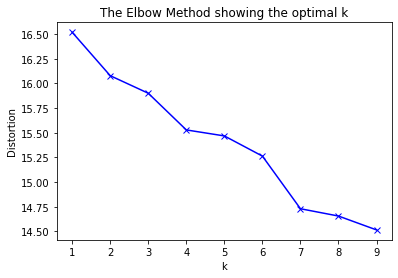

In [127]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(london_grouped_clustering_norm)
    kmeanModel.fit(london_grouped_clustering_norm)
    distortions.append(sum(np.min(cdist(london_grouped_clustering_norm, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / london_grouped_clustering_norm.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### Silhouette score of Normalised Data

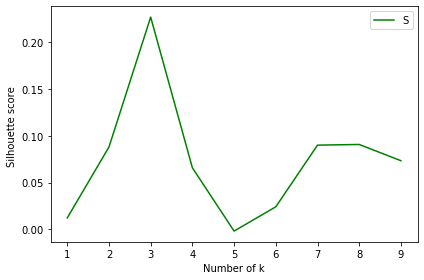

In [132]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(london_grouped_clustering_norm)
    labels = kmeans.labels_
    sil.append(silhouette_score(london_grouped_clustering_norm, labels, metric = 'euclidean'))
    
plt.plot(range(1,kmax),sil,'g')
plt.legend('Silhouette score')
plt.ylabel('Silhouette score ')
plt.xlabel('Number of k')
plt.tight_layout()
plt.show()

#### So we choose k = 7

In [140]:
kclusters = 7

#run kmeans clustering
kmeans = KMeans(n_clusters= kclusters, random_state= 0).fit(london_grouped_clustering_norm)
kmeans.labels_[0:10]

array([1, 6, 3, 6, 3, 3, 6, 3, 3, 3], dtype=int32)

## Let's create a new dataframe that includes the cluster as well as the top 5 venues for each Location(neighborhood).

In [141]:
londonNeigh_venues_sorted.insert( 0, 'Cluster Labels', kmeans.labels_)

london_merged = london_data

# merge london_grouped with toronto_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(londonNeigh_venues_sorted.set_index('Location'), on='Location')

london_merged.head() # check the last columns!

Location London borough Post town Postcode district  Avg price    £/sqm  \
0  Abbey Wood         Bexley    LONDON               SE2     368814   4133.4   
1   Crossness         Bexley    LONDON               SE2     368814   4133.4   
2  West Heath         Bexley    LONDON               SE2     368814   4133.4   
3       Acton         Ealing    LONDON                W3     547488   7330.3   
4     Aldwych    Westminster    LONDON               WC2    1662350  17599.1   

   Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0  51.49245    0.12127               1           Supermarket   
1  51.49245    0.12127               1           Supermarket   
2  51.49245    0.12127               1           Supermarket   
3  51.51324   -0.26746               6         Grocery Store   
4  51.51651   -0.11968               3        Sandwich Place   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0           Coffee Shop              Platform     Convenience Store   
1           Coffee Shop              Platform     Convenience Store   
2           Coffee Shop              Platform     Convenience Store   
3         Train Station                  Park     Indian Restaurant   
4                   Pub               Theater                  Café   

  5th Most Common Venue     Price  
0         Train Station  0.044347  
1         Train Station  0.160450  
2         Train Station  0.228340  
3        Breakfast Spot  0.044347  
4           Coffee Shop  0.044347

In [142]:
london_merged.shape

(300, 15)

In [143]:
#drop any null values
london_merged.dropna(inplace=True)
london_merged.shape

(300, 15)

In [144]:
# london_merged['Cluster Labels'] = london_merged['Cluster Labels'].astype(int) #if I had to change the type of the labels
london_merged.dtypes

Location                  object
London borough            object
Post town                 object
Postcode district         object
Avg price                  int64
£/sqm                    float64
Latitude                 float64
Longitude                float64
Cluster Labels             int32
1st Most Common Venue     object
2nd Most Common Venue     object
3rd Most Common Venue     object
4th Most Common Venue     object
5th Most Common Venue     object
Price                    float64
dtype: object

### lets visualise the resulting clusters- I havent manage to make this work with the different colours yet

In [146]:
# create a map
map_clusters = folium.Map(location = [latitude, longitude], zoom_start= 11)

#set colors scheme for clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]

#ys is a list which is made via for loop which runs till the value of kclusters and for each value of it will execute the equation i+x+(i+x)**2.
colors_array = cm.rainbow(np.linspace(0, 1, len(ys))) #np.linspace creates evenly gapped sequence between 0 to 1 , for length size. and cm.rainbow is used to make colormaps.
rainbow = [colors.rgb2hex(i) for i in colors_array] #colors.rgb2hex converts numbers to colors.

#add markers to the map
markers_colors = []
for lat, lng, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Location'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + 'Cluster' + str(cluster), parse_html = True)
    folium.CircleMarker(
    [lat, lng],
    radius = 5,
    popup = label, 
    color = rainbow[cluster-1],
    fill = True,
    fill_color = rainbow[cluster-1],
    fill_opacity = 0.7).add_to(map_clusters)
    
map_clusters

## Binning

Lets understand the average prices

In [155]:
london_merged["Avg price"].min()

274499

In [156]:
london_merged["Avg price"].max()

2401261

In [157]:
london_merged["Avg price"].count()

300

In [158]:
#I want to understand max-min so this is divisible by XX to create my bin boundaries
(london_merged["Avg price"].max() - london_merged["Avg price"].min())/20

106338.1

Text(0.5, 1.0, 'Price bins')

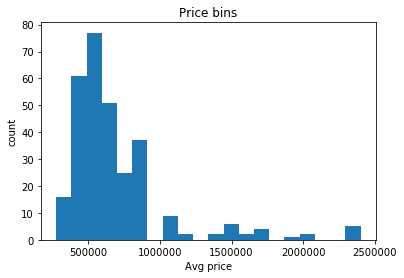

In [159]:
plt.hist(london_merged["Avg price"],bins=20)

# set x/y labels and plot title
plt.xlabel("Avg price")
plt.ylabel("count")
plt.title("Price bins")

Text(0.5, 1.0, 'Price bins')

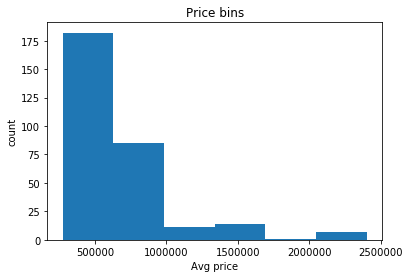

In [160]:
plt.hist(london_merged["Avg price"],bins=6)

# set x/y labels and plot title
plt.xlabel("Avg price")
plt.ylabel("count")
plt.title("Price bins")

In [161]:
bins = np.linspace(min(london_merged["Avg price"]), max(london_merged["Avg price"]), 7)
bins

array([ 274499.        ,  628959.33333333,  983419.66666667,
       1337880.        , 1692340.33333333, 2046800.66666667,
       2401261.        ])

In [162]:
group_names = ['Low level 1', 'Low level 2', 'Average level 1', 'Average level 2','High level 1','High level 2']

In [163]:
london_merged['Price-Categories'] = pd.cut(london_merged['Avg price'], bins, labels=group_names, include_lowest=True )
london_merged[['Avg price','Price-Categories']].head()

Avg price Price-Categories
0     368814      Low level 1
1     368814      Low level 1
2     368814      Low level 1
3     547488      Low level 1
4    1662350  Average level 2

### Cluster bins

Creating 7 bins of cluster based on the k-means

Text(0.5, 1.0, 'Cluster Labels')

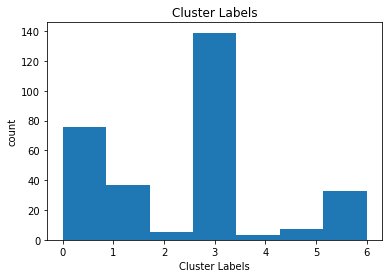

In [164]:
plt.hist(london_merged["Cluster Labels"],bins=7)

# set x/y labels and plot title
plt.xlabel("Cluster Labels")
plt.ylabel("count")
plt.title("Cluster Labels")

In [165]:
bins_cl = np.linspace(min(london_merged["Cluster Labels"]), max(london_merged["Cluster Labels"]), 8)
bins_cl

array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
       4.28571429, 5.14285714, 6.        ])

## 5. Examine the clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.

Cluster 1

In [166]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[1]+ list(range(5, london_merged.shape[1]))]]

London borough   £/sqm  Latitude  Longitude  Cluster Labels  \
30   Richmond upon Thames  9504.6  51.47457   -0.24212               0   
31   Richmond upon Thames  9504.6  51.47457   -0.24212               0   
45                 Newham  4520.9  51.53292    0.05461               0   
46                 Newham  4520.9  51.53292    0.05461               0   
47                 Newham  4520.9  51.53292    0.05461               0   
..                    ...     ...       ...        ...             ...   
290        Waltham Forest  6264.6  51.58477   -0.01943               0   
291        Waltham Forest  6264.6  51.58477   -0.01943               0   
292        Waltham Forest  6264.6  51.58477   -0.01943               0   
293             Southwark  7631.7  51.48764   -0.09542               0   
297               Lambeth  6167.8  51.43407   -0.10375               0   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
30            Pizza Place     Food & Drink Shop                   Pub   
31            Pizza Place     Food & Drink Shop                   Pub   
45   Fast Food Restaurant        Clothing Store                   Pub   
46   Fast Food Restaurant        Clothing Store                   Pub   
47   Fast Food Restaurant        Clothing Store                   Pub   
..                    ...                   ...                   ...   
290           Coffee Shop                  Café                   Pub   
291           Coffee Shop                  Café                   Pub   
292           Coffee Shop                  Café                   Pub   
293                  Café                   Pub                  Park   
297                   Pub         Grocery Store                Bakery   

    4th Most Common Venue 5th Most Common Venue     Price Price-Categories  
30         Farmers Market                  Park  0.290263  Average level 1  
31         Farmers Market                  Park  0.046447  Average level 1  
45         Discount Store                  Café  0.290263      Low level 1  
46         Discount Store                  Café  0.154103      Low level 1  
47         Discount Store                  Café  0.063269      Low level 1  
..                    ...                   ...       ...              ...  
290        Sandwich Place        Clothing Store  0.047562      Low level 1  
291        Sandwich Place        Clothing Store  0.063269      Low level 1  
292        Sandwich Place        Clothing Store  0.196462      Low level 1  
293                Hostel           Music Venue  0.113683      Low level 1  
297     Recreation Center                  Café  0.095610      Low level 1  

[76 rows x 12 columns]

Cluster 2

In [167]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[1]+ list(range(5, london_merged.shape[1]))]]

London borough   £/sqm  Latitude  Longitude  Cluster Labels  \
0           Bexley  4133.4  51.49245    0.12127               1   
1           Bexley  4133.4  51.49245    0.12127               1   
2           Bexley  4133.4  51.49245    0.12127               1   
70        Lewisham  6404.6  51.47138    0.02338               1   
71       Greenwich  6404.6  51.47138    0.02338               1   
72       Greenwich  6404.6  51.47138    0.02338               1   
73       Greenwich  6404.6  51.47138    0.02338               1   
74   Tower Hamlets  7933.1  51.51122   -0.01264               1   
75   Tower Hamlets  7933.1  51.51122   -0.01264               1   
76   Tower Hamlets  7933.1  51.51122   -0.01264               1   
77   Tower Hamlets  7933.1  51.51122   -0.01264               1   
78   Tower Hamlets  7933.1  51.51122   -0.01264               1   
79   Tower Hamlets  7933.1  51.51122   -0.01264               1   
80   Tower Hamlets  7933.1  51.51122   -0.01264               1   
81   Tower Hamlets  7933.1  51.51122   -0.01264               1   
86   Tower Hamlets  6953.5  51.52702   -0.02594               1   
87   Tower Hamlets  6953.5  51.52702   -0.02594               1   
88   Tower Hamlets  6953.5  51.52702   -0.02594               1   
89        Haringey  6619.9  51.60214   -0.11223               1   
90        Haringey  6619.9  51.60214   -0.11223               1   
145         Barnet  6006.3  51.58486   -0.24881               1   
146         Barnet  6006.3  51.58486   -0.24881               1   
147         Barnet  6006.3  51.58486   -0.24881               1   
148          Brent  6006.3  51.58486   -0.24881               1   
149         Barnet  6006.3  51.58486   -0.24881               1   
169      Southwark  7750.1  51.45256   -0.07076               1   
176      Greenwich  4596.2  51.44463    0.05212               1   
177         Bexley  4596.2  51.44463    0.05212               1   
178         Bexley  4596.2  51.44463    0.05212               1   
179      Greenwich  4596.2  51.44463    0.05212               1   
180        Bromley  4596.2  51.44463    0.05212               1   
181      Greenwich  4596.2  51.44463    0.05212               1   
182      Greenwich  4596.2  51.44463    0.05212               1   
205        Hackney  7976.1  51.53777   -0.04480               1   
206        Hackney  7976.1  51.53777   -0.04480               1   
207        Hackney  7976.1  51.53777   -0.04480               1   
208        Hackney  7976.1  51.53777   -0.04480               1   

    1st Most Common Venue       2nd Most Common Venue 3rd Most Common Venue  \
0             Supermarket                 Coffee Shop              Platform   
1             Supermarket                 Coffee Shop              Platform   
2             Supermarket                 Coffee Shop              Platform   
70                    Pub          Photography Studio        Farmers Market   
71                    Pub          Photography Studio        Farmers Market   
72                    Pub          Photography Studio        Farmers Market   
73                    Pub          Photography Studio        Farmers Market   
74                   Park          English Restaurant           Coffee Shop   
75                   Park          English Restaurant           Coffee Shop   
76                   Park          English Restaurant           Coffee Shop   
77                   Park          English Restaurant           Coffee Shop   
78                   Park          English Restaurant           Coffee Shop   
79                   Park          English Restaurant           Coffee Shop   
80                   Park          English Restaurant           Coffee Shop   
81                   Park          English Restaurant           Coffee Shop   
86                    Pub               Grocery Store   Rental Car Location   
87                    Pub               Grocery Store   Rental Car Location   
88                    Pub          

Cluster 3

In [168]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[1]+ list(range(5, london_merged.shape[1]))]]

London borough    £/sqm  Latitude  Longitude  Cluster Labels  \
132    Westminster  17922.1  51.51656    -0.1477               2   
133         Camden  17922.1  51.51656    -0.1477               2   
134    Westminster  17922.1  51.51656    -0.1477               2   
135    Westminster  17922.1  51.51656    -0.1477               2   
136    Westminster  17922.1  51.51656    -0.1477               2   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
132           Coffee Shop        Clothing Store                   Spa   
133           Coffee Shop        Clothing Store                   Spa   
134           Coffee Shop        Clothing Store                   Spa   
135           Coffee Shop        Clothing Store                   Spa   
136           Coffee Shop        Clothing Store                   Spa   

    4th Most Common Venue 5th Most Common Venue     Price Price-Categories  
132                 Hotel     French Restaurant  0.594548     High level 2  
133                 Hotel     French Restaurant  0.132427     High level 2  
134                 Hotel     French Restaurant  0.170813     High level 2  
135                 Hotel     French Restaurant  0.170813     High level 2  
136                 Hotel     French Restaurant  0.123728     High level 2

Cluster 4

In [169]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[1]+ list(range(5, london_merged.shape[1]))]]

London borough    £/sqm  Latitude  Longitude  Cluster Labels  \
4               Westminster  17599.1  51.51651   -0.11968               3   
5               Westminster  17599.1  51.51651   -0.11968               3   
6               Westminster  17599.1  51.51651   -0.11968               3   
7                    Camden  17599.1  51.51651   -0.11968               3   
10                Islington  11678.9  51.52361   -0.09877               3   
..                      ...      ...       ...        ...             ...   
294  Kensington and Chelsea  13508.8  51.48563   -0.18144               3   
295                  Ealing   7319.5  51.51453   -0.31951               3   
296  Hammersmith and Fulham  10720.9  51.49568   -0.20993               3   
298               Redbridge   5414.3  51.50642   -0.12721               3   
299               Redbridge   5414.3  51.50642   -0.12721               3   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
4          Sandwich Place                   Pub               Theater   
5          Sandwich Place                   Pub               Theater   
6          Sandwich Place                   Pub               Theater   
7          Sandwich Place                   Pub               Theater   
10             Food Truck           Coffee Shop                   Pub   
..                    ...                   ...                   ...   
294    Italian Restaurant                Bakery         Grocery Store   
295         Grocery Store     Indian Restaurant    Persian Restaurant   
296                 Hotel                   Pub         Grocery Store   
298                 Hotel                 Plaza               Theater   
299                 Hotel                 Plaza               Theater   

    4th Most Common Venue 5th Most Common Venue     Price Price-Categories  
4                    Café           Coffee Shop  0.044347  Average level 2  
5                    Café           Coffee Shop  0.218559  Average level 2  
6                    Café           Coffee Shop  0.361649  Average level 2  
7                    Café           Coffee Shop  0.048912  Average level 2  
10     Italian Restaurant                 Hotel  0.652565      Low level 2  
..                    ...                   ...       ...              ...  
294             Juice Bar          Gourmet Shop  0.113054  Average level 1  
295    Turkish Restaurant           Fish Market  0.113054      Low level 1  
296     Indian Restaurant    Persian Restaurant  0.228340      Low level 2  
298          Burger Joint   Monument / Landmark  0.143111      Low level 1  
299          Burger Joint   Monument / Landmark  0.437642      Low level 1  

[139 rows x 12 columns]

Cluster 5

In [170]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[1]+ list(range(5, london_merged.shape[1]))]]

London borough   £/sqm  Latitude  Longitude  Cluster Labels  \
218      Islington  8169.9  51.55457   -0.11478               4   
219      Islington  8169.9  51.55457   -0.11478               4   
220      Islington  8169.9  51.55457   -0.11478               4   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
218                  Café                   Pub           Supermarket   
219                  Café                   Pub           Supermarket   
220                  Café                   Pub           Supermarket   

    4th Most Common Venue 5th Most Common Venue     Price Price-Categories  
218        Soccer Stadium  Gym / Fitness Center  0.086713      Low level 1  
219        Soccer Stadium  Gym / Fitness Center  0.295872      Low level 1  
220        Soccer Stadium  Gym / Fitness Center  0.228066      Low level 1

Cluster 6

In [171]:
london_merged.loc[london_merged['Cluster Labels'] == 5, london_merged.columns[[1]+ list(range(5, london_merged.shape[1]))]]

London borough   £/sqm  Latitude  Longitude  Cluster Labels  \
35      Islington  9989.0  51.52969   -0.08697               5   
36      Islington  9989.0  51.52969   -0.08697               5   
37      Islington  9989.0  51.52969   -0.08697               5   
38        Hackney  9989.0  51.52969   -0.08697               5   
39      Islington  9989.0  51.52969   -0.08697               5   
40      Islington  9989.0  51.52969   -0.08697               5   
41        Hackney  9989.0  51.52969   -0.08697               5   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
35           Coffee Shop                   Pub        Breakfast Spot   
36           Coffee Shop                   Pub        Breakfast Spot   
37           Coffee Shop                   Pub        Breakfast Spot   
38           Coffee Shop                   Pub        Breakfast Spot   
39           Coffee Shop                   Pub        Breakfast Spot   
40           Coffee Shop                   Pub        Breakfast Spot   
41           Coffee Shop                   Pub        Breakfast Spot   

   4th Most Common Venue 5th Most Common Venue     Price Price-Categories  
35                  Café          Cocktail Bar  0.290263      Low level 2  
36                  Café          Cocktail Bar  0.046447      Low level 2  
37                  Café          Cocktail Bar  0.113616      Low level 2  
38                  Café          Cocktail Bar  0.102402      Low level 2  
39                  Café          Cocktail Bar  1.000000      Low level 2  
40                  Café          Cocktail Bar  0.183618      Low level 2  
41                  Café          Cocktail Bar  0.060652      Low level 2

Cluster 7

In [172]:
london_merged.loc[london_merged['Cluster Labels'] == 6, london_merged.columns[[1]+ list(range(5, london_merged.shape[1]))]]

London borough   £/sqm  Latitude  Longitude  Cluster Labels  \
3           Ealing  7330.3  51.51324   -0.26746               6   
8          Bromley  5500.4  51.41009   -0.05683               6   
9          Bromley  5500.4  51.41009   -0.05683               6   
18         Enfield  5823.3  51.61631   -0.13839               6   
19        Haringey  5823.3  51.61631   -0.13839               6   
20          Barnet  5823.3  51.61631   -0.13839               6   
21          Barnet  5823.3  51.61631   -0.13839               6   
22          Barnet  5823.3  51.61631   -0.13839               6   
23          Barnet  5823.3  51.61631   -0.13839               6   
58        Lewisham  5220.5  51.43722   -0.01868               6   
59        Lewisham  5220.5  51.43722   -0.01868               6   
60        Lewisham  5220.5  51.43722   -0.01868               6   
117      Southwark  7093.5  51.47480   -0.09313               6   
118      Southwark  7093.5  51.47480   -0.09313               6   
137       Lewisham  4876.1  51.44759    0.01350               6   
139      Greenwich  4876.1  51.44759    0.01350               6   
140       Lewisham  4876.1  51.44759    0.01350               6   
183       Haringey  8191.4  51.56878   -0.09847               6   
184       Haringey  8191.4  51.56878   -0.09847               6   
185        Hackney  8191.4  51.56878   -0.09847               6   
186       Haringey  8191.4  51.56878   -0.09847               6   
187         Newham  5016.0  51.54668    0.02558               6   
202        Hackney  7308.8  51.55897   -0.05323               6   
203        Hackney  7308.8  51.55897   -0.05323               6   
204        Hackney  7308.8  51.55897   -0.05323               6   
210         Ealing  6286.2  51.50878   -0.33630               6   
265      Greenwich  5016.0  51.48207    0.07143               6   
266      Greenwich  5016.0  51.48207    0.07143               6   
267      Greenwich  5016.0  51.48207    0.07143               6   
268         Merton  7104.2  51.41117   -0.22623               6   
271        Croydon  4843.8  51.39925   -0.07414               6   
272        Croydon  4843.8  51.39925   -0.07414               6   
287         Bexley  3928.9  51.50527    0.12013               6   

    1st Most Common Venue 2nd Most Common Venue   3rd Most Common Venue  \
3           Grocery Store         Train Station                    Park   
8             Supermarket                 Hotel    Fast Food Restaurant   
9             Supermarket                 Hotel    Fast Food Restaurant   
18          Grocery Store              Bus Stop           Metro Station   
19          Grocery Store              Bus Stop           Metro Station   
20          Grocery Store              Bus Stop           Metro Station   
21          Grocery Store              Bus Stop           Metro Station   
22          Grocery Store              Bus Stop           Metro Station   
23          Grocery Store              Bus Stop           Metro Station   
58          Grocery Store        Discount Store  Furniture / Home Store   
59          Grocery Store        Discount Store  Furniture / Home Store   
60          Grocery Store        Discount Store  Furniture / Home Store   
117                  Café                   Pub                Bus Stop   
118                  Café                   Pub                Bus Stop   
137                   Pub         Train Station     Fried Chicken Joint   
139                   Pub         Train Station     Fried Chicken Joint   
140                   Pub         Train Station     Fried Chicken Joint   
183                 Hotel                   Pub             Pizza Place   
184                 Hotel                   Pub             Pizza Place   
185                 Hotel                   Pub             Pizza Place   
186                 Hotel                   Pub             Pizza Place   
187         Grocery Store              Bus Stop                     Pub   


In [173]:
group_names_cl = ['Restaurants','Mixed Social Venues','Touristic Places (cafe - hotel)', 'Light bites', 'Cafe & Sports events','All day social venues', 'Stores and fast foods']

In [174]:
london_merged['Cluster-Category'] = pd.cut(london_merged['Cluster Labels'], bins_cl, labels=group_names_cl, include_lowest=True )
london_merged[['Cluster Labels','Cluster-Category']].head()

Cluster Labels       Cluster-Category
0               1    Mixed Social Venues
1               1    Mixed Social Venues
2               1    Mixed Social Venues
3               6  Stores and fast foods
4               3            Light bites

In [177]:
london_merged.head(10)

Location London borough Post town Postcode district  Avg price  \
0     Abbey Wood         Bexley    LONDON               SE2     368814   
1      Crossness         Bexley    LONDON               SE2     368814   
2     West Heath         Bexley    LONDON               SE2     368814   
3          Acton         Ealing    LONDON                W3     547488   
4        Aldwych    Westminster    LONDON               WC2    1662350   
5  Charing Cross    Westminster    LONDON               WC2    1662350   
6  Covent Garden    Westminster    LONDON               WC2    1662350   
7       St Giles         Camden    LONDON               WC2    1662350   
8        Anerley        Bromley    LONDON              SE20     348970   
9          Penge        Bromley    LONDON              SE20     348970   

     £/sqm  Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0   4133.4  51.49245    0.12127               1           Supermarket   
1   4133.4  51.49245    0.12127               1           Supermarket   
2   4133.4  51.49245    0.12127               1           Supermarket   
3   7330.3  51.51324   -0.26746               6         Grocery Store   
4  17599.1  51.51651   -0.11968               3        Sandwich Place   
5  17599.1  51.51651   -0.11968               3        Sandwich Place   
6  17599.1  51.51651   -0.11968               3        Sandwich Place   
7  17599.1  51.51651   -0.11968               3        Sandwich Place   
8   5500.4  51.41009   -0.05683               6           Supermarket   
9   5500.4  51.41009   -0.05683               6           Supermarket   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0           Coffee Shop              Platform     Convenience Store   
1           Coffee Shop              Platform     Convenience Store   
2           Coffee Shop              Platform     Convenience Store   
3         Train Station                  Park     Indian Restaurant   
4                   Pub               Theater                  Café   
5                   Pub               Theater                  Café   
6                   Pub               Theater                  Café   
7                   Pub               Theater                  Café   
8                 Hotel  Fast Food Restaurant     Convenience Store   
9                 Hotel  Fast Food Restaurant     Convenience Store   

  5th Most Common Venue     Price Price-Categories       Cluster-Category  
0         Train Station  0.044347      Low level 1    Mixed Social Venues  
1         Train Station  0.160450      Low level 1    Mixed Social Venues  
2         Train Station  0.228340      Low level 1    Mixed Social Venues  
3        Breakfast Spot  0.044347      Low level 1  Stores and fast foods  
4           Coffee Shop  0.044347  Average level 2            Light bites  
5           Coffee Shop  0.218559  Average level 2            Light bites  
6           Coffee Shop  0.361649  Average level 2            Light bites  
7           Coffee Shop  0.048912  Average level 2            Light bites  
8         Grocery Store  0.128359      Low level 1  Stores and fast foods  
9         Grocery Store  0.183618      Low level 1  Stores and fast foods

### Creating Chloropeth map to visualise how London is divided in terms of Real estate pricing and cluster markers on the top

In [178]:
lnd_geo = r'london_boroughs_proper.geojson'
lnd_map = folium.Map(location = [latitude, longitude], zoom_start = 11)

lnd_map.choropleth(
    geo_data=lnd_geo,
    data=london_merged,
    columns=['London borough','Avg price'],
    key_on='feature.properties.name',
    fill_color='RdPu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average house Prices'
)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'],london_merged['Longitude'], london_merged['Location'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(lnd_map)
       
# display map
lnd_map

In [179]:
lnd_geo = r'london_boroughs_proper.geojson'
lnd_map = folium.Map(location = [latitude, longitude], zoom_start = 10)

lnd_map.choropleth(
    geo_data=lnd_geo,
    data=london_merged,
    columns=['London borough','Cluster Labels'],
    key_on='feature.properties.name',
    fill_color='PuRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Cluster Labels'
)

lnd_map